# ECG Sparsity

GOAL: study the sparsity of ECG signals

In [1]:
%matplotlib widget

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

In [4]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy import io

from synthetic_ecg import load_synthetic_ecg
from wavelet_basis import wavelet_basis

## Dataset

The dataset has been generated with [ECGSYN](https://physionet.org/content/ecgsyn/1.0.0/). 
The heart-beat rate is randomly set using an uniform distribution between 60 and 100 beat/minute. We generate chunks of 2s with a 256sample/s sampling frequency, that are split into windows
of n subsequent samples.

In [5]:
ecg_seed = 0  # seed to shuffle and sample the generated dataset
n = 128  # sample dimension

X = load_synthetic_ecg(sample_dimension=n, seed=ecg_seed)

## Generate Wavelet Sparsity Basis

In [6]:
level = 2  # coarsest level of the Wavelet Decomposition

S = wavelet_basis(n, 'sym6', level=level)

check whether the generated sparsity matrix corresponds to the one generated with MATLAB.

mean squared difference: 2.477e-19


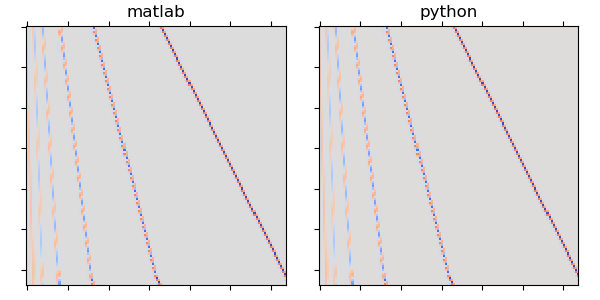

In [7]:
Smat = io.loadmat(f'/srv/newpenny/dnn-cs/JETCAS2020/data/Sym6-D_n{n}.mat')['D']

vmax = max(np.max(np.abs(S)), np.max(np.abs(Smat)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.matshow(Smat, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax1.set(title='matlab')
ax2.matshow(S, cmap='coolwarm', vmin=-vmax, vmax=vmax)
ax2.set(title='python')
for ax in (ax1, ax2):
    ticks = np.arange(0, 1 + n, 2**(np.log2(n) - 2))
    ax.set(xticklabels=[], yticklabels=[], )
fig.tight_layout()

mse = np.sum((Smat - S))**2
print(f'mean squared difference: {mse:.3e}')


Basis vectors by level

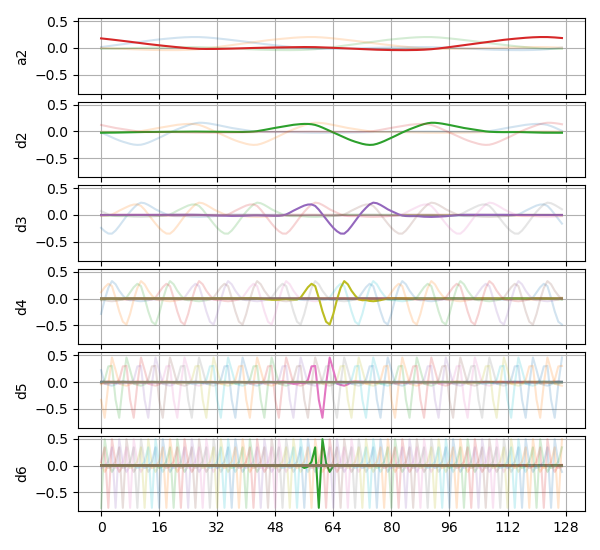

In [8]:
n = 128  # sample dimension
level = 2  # coarsest level of the Wavelet Decomposition

levels = int(np.ceil(np.log2(n)))

S = wavelet_basis(n, wavelet='sym6', level=level)

nrows = levels - level + 1
fig, axs = plt.subplots(nrows, 1, sharex='all', sharey='all', figsize=(6, 1+0.75*nrows))
for i in range(2**level):
    axs[0].plot(S[:, i], alpha=1 if i == 2**level - 1 else .2)
    axs[0].set(ylabel=f'a{level}')
for ax, l in zip(axs[1:], range(level, levels+1)):
    for i in range(2**l):
        ax.plot(S[:, 2**l + i], alpha=1 if i == 2**(l-1) else .2)
    ax.set(ylabel=f'd{l}')
for ax in axs:
    ax.set(xticks=range(0, 1 + 2**levels, 2**(levels-3)))
    ax.grid()
fig.tight_layout(h_pad=0.)

## Samples in the sparsity domain

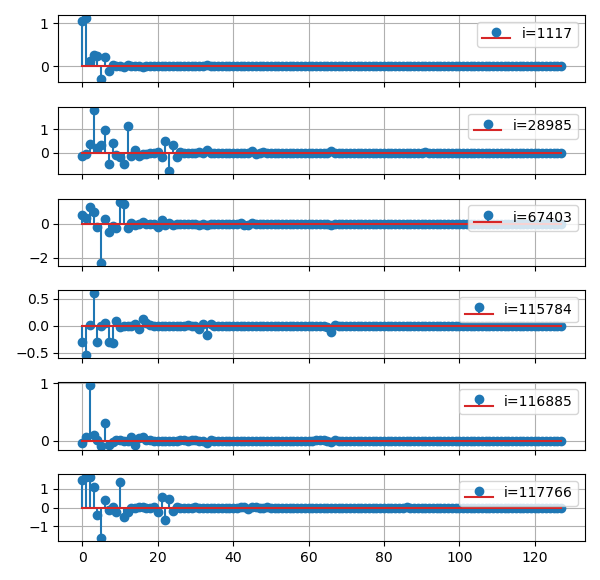

In [9]:
nrows = 6    # number of examples

Xi = X @ S
ii = np.sort(np.random.randint(len(Xi), size=nrows))

fig, axs = plt.subplots(nrows, 1, figsize=(6, 1 + .8*nrows), sharex='all')
for ax, i in zip(axs, ii):
    ax.stem(Xi[i], label=f'i={i}')
    ax.grid()
    ax.legend(loc='upper right')

fig.tight_layout()

## Dataset Sparsity

In [10]:
def sparsity(x, threshold=0.99):
    ''' Compute sparsity of a ndarray along the last axis 
    given an energy threshold '''
    tmp = np.sort(x**2, axis=-1)[..., ::-1]
    tmp = np.cumsum(tmp, axis=-1) / np.sum(tmp, axis=-1)[..., None]
    k = np.sum(tmp < threshold, axis=-1)
    return k

In [11]:
level_list = (0, 1, 2, 3)  # coarsest level of the Wavelet Decomposition

# threshold in energy fraction for signal sparsification
threshold_list = (0.9, 0.99, 0.999)  

ks = pd.DataFrame(
    columns=pd.MultiIndex.from_product(
        (level_list, threshold_list), names=('level', 'threshold')),
)

for level in level_list:
    S = wavelet_basis(n, wavelet='sym6', level=level)
    Xi = X @ S
    for threshold in threshold_list:
        ks[(level, threshold)] = sparsity(Xi, threshold=threshold)

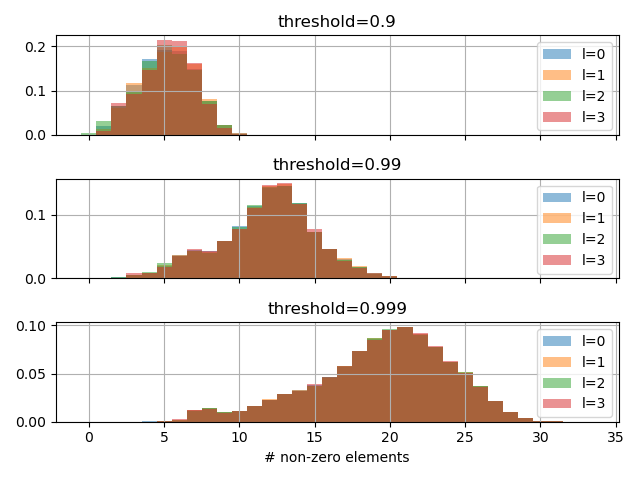

In [12]:
fig, axs = plt.subplots(len(threshold_list), 1, sharex='all')

ebins = np.arange(2 + ks.max().max()) - 0.5
for ax, threshold in zip(axs, threshold_list):
    for level, k in ks.xs(threshold, level='threshold', axis=1).items():
        ax.hist(k, bins=ebins, density=True, alpha=0.5, label=f'l={level}')
    ax.set(title=f'threshold={threshold}')
    ax.grid()
    ax.legend()
axs[-1].set(xlabel='# non-zero elements')
fig.tight_layout()

In [13]:

for threshold in threshold_list:
    print(f'threshold: {threshold}')
    display(ks.xs(threshold, level='threshold', axis=1).describe())


threshold: 0.9


level,0,1,2,3
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,5.153300,5.255240,5.091245,5.240285
std,1.858079,1.841209,1.909544,1.760575
min,0.000000,0.000000,0.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000
50%,5.000000,5.000000,5.000000,5.000000
75%,7.000000,7.000000,6.000000,7.000000
max,12.000000,12.000000,11.000000,11.000000


threshold: 0.99


level,0,1,2,3
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,11.788805,11.827595,11.766175,11.816605
std,3.202617,3.196990,3.226402,3.191929
min,0.000000,1.000000,1.000000,2.000000
25%,10.000000,10.000000,10.000000,10.000000
50%,12.000000,12.000000,12.000000,12.000000
75%,14.000000,14.000000,14.000000,14.000000
max,24.000000,24.000000,23.000000,24.000000


threshold: 0.999


level,0,1,2,3
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,19.436490,19.446330,19.427560,19.441175
std,4.627105,4.627378,4.630154,4.625448
min,2.000000,3.000000,3.000000,4.000000
25%,17.000000,17.000000,17.000000,17.000000
50%,20.000000,20.000000,20.000000,20.000000
75%,23.000000,23.000000,23.000000,23.000000
max,33.000000,33.000000,33.000000,33.000000
